In [1]:
'''
Library declare
@Author: MinHyung Lee
@Since: 2022/05/22
Used library:
pandas
numpy
featuretools
matplot
sklearn
seaborn

'''

import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import  r_regression, SelectKBest
from sklearn.pipeline import make_pipeline

from woodwork.logical_types import Categorical, Boolean
from sklearn.preprocessing import OrdinalEncoder
from math import sqrt, log10, ceil
'''
Add plt config
@Author: MinHyung Lee
@Since: 2022/05/24

'''

import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.dpi'] = 600

pd.set_option('display.max_rows', 20)

random_state = 7777
unusable_col = ['Unnamed: 0', 'App Name', 'App Id', 'Minimum Installs', 'Price', 'Currency', 'Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Last Updated', 'Editors Choice', 'Scraped Time', 'Free', 'Rating Count', 'Rating']

In [19]:


df = pd.read_csv('Google-Playstore(new).csv')

# 필요없는 컬럼 버리기
df = df.drop(unusable_col, axis=1)

# 숫자로 되어 있지 않은 컬럼 숫자로 인코딩하기
encoding = OrdinalEncoder()
encoding.fit(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']])
df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']] = encoding.transform(df[['Category', 'Minimum Android', 'Content Rating', 'Ad Supported', 'In App Purchases', 'Installs']])

# Size 컬럼 인코딩
A = df[df['Size'] == 'Varies with device'].index
df = df.drop(A,axis='index')
df = df.dropna()  # NaN가 포함된 데이터는 모두 drop
# 앱 크기 사이즈 계산
# 1. ','drop
# 2. M과 k drop
# 3. k값 M으로 치환
df['Size'] =  np.where(df['Size'].str.contains('M'), df['Size'].str.replace(',','').str[:-1].astype('float64') , df['Size'].str.replace(',','').str[:-1].astype('float64')/1000)

# 날짜 월만 남기고 버리고 인코딩
df['Released'] = pd.to_datetime(df['Released'])
df['Released'].dt.strftime('%b %d, %Y')
df['Released'] = df['Released'].dt.strftime('%Y-%m-%d')

df.fillna(df.mean(), inplace=True)

test_df = df["Installs"]
test_df.to_csv("targetForKNN.csv")
df.drop(['Installs'], axis= 1, inplace=True)


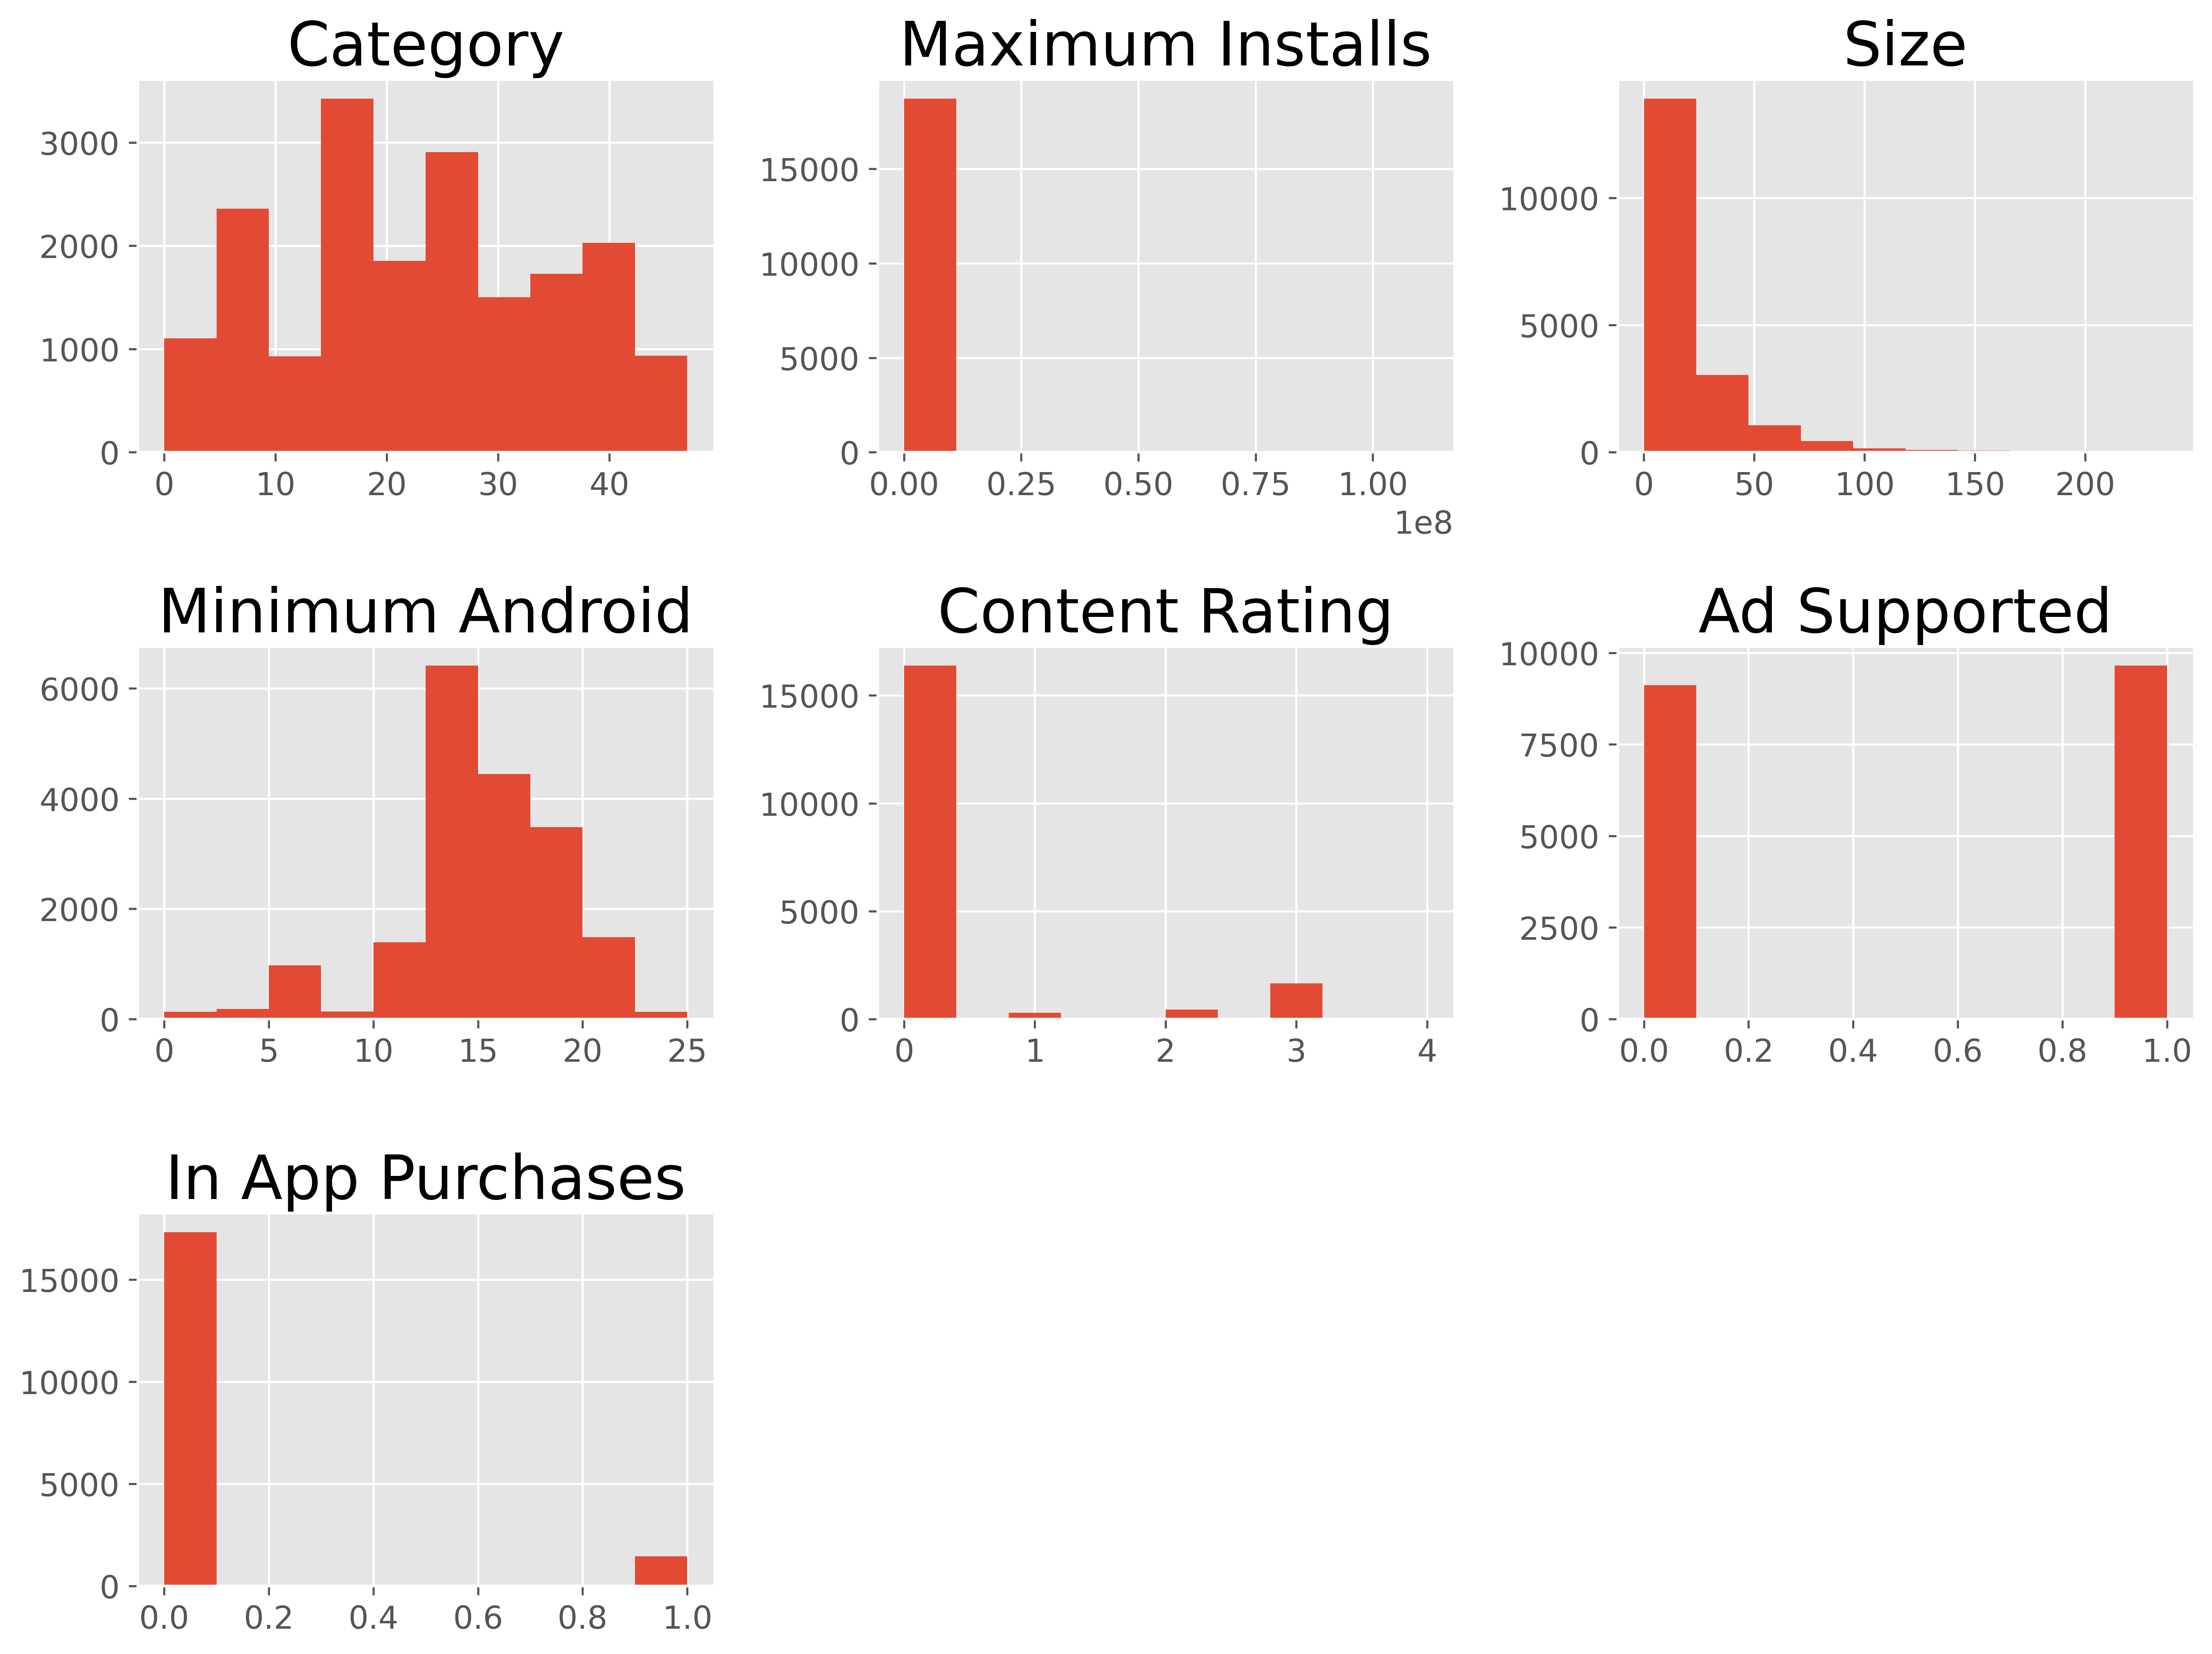

In [4]:
'''

@Author: MinHyung Lee
@Since: 2022/05/31
최종 feature

'''

def make_subplot_layout(df, col_num):
    k = len(df.columns)
    row_num = ceil(k/col_num)
    for i in range(k) :
        plt.subplot(row_num,col_num,i+1)
        plt.hist(df.iloc[:,i])
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

make_subplot_layout(df.drop('Released', axis=1, inplace=False), 3)

In [5]:
es = ft.EntitySet(id='Store')
df["index"] = df.index

In [6]:
es.add_dataframe(dataframe_name="store_log",
                 dataframe=df,
                 index="index",
                 logical_types= {
                     "Ad Supported": Boolean,
                     "In App Purchases": Boolean,
                     "Category": Categorical,
                     "Minimum Android": Categorical
                 })

Entityset: Store
  DataFrames:
    store_log [Rows: 18777, Columns: 9]
  Relationships:
    No relationships

In [7]:
#Check dataset schema briefly
es["store_log"].ww.schema

Logical Type Semantic Tag(s)
Column                                       
Category          Categorical    ['category']
Maximum Installs      Integer     ['numeric']
Size                   Double     ['numeric']
Minimum Android   Categorical    ['category']
Released             Datetime              []
Content Rating         Double     ['numeric']
Ad Supported          Boolean              []
In App Purchases      Boolean              []
index                 Integer       ['index']

In [8]:
pd.set_option('display.max_rows', 20)
ft.list_primitives()

name         type  dask_compatible  \
0                          min  aggregation             True   
1                n_most_common  aggregation            False   
2                         mean  aggregation             True   
3             time_since_first  aggregation            False   
4                          all  aggregation             True   
..                         ...          ...              ...   
96                rolling_mean    transform            False   
97   less_than_equal_to_scalar    transform             True   
98                 square_root    transform             True   
99            multiply_boolean    transform             True   
100                numeric_lag    transform            False   

     spark_compatible                                        description  \
0                True  Calculates the smallest value, ignoring `NaN` ...   
1               False           Determines the `n` most common elements.   
2                True         Computes the average for a list of values.   
3               False  Calculates the time elapsed since the first da...   
4               False     Calculates if all values are 'True' in a list.   
..                ...                                                ...   
96              False  Calculates the mean of entries over a given wi...   
97               True  Determines if values are less than or equal to...   
98               True              Computes the square root of a number.   
99              False  Element-wise multiplication of two lists of bo...   
100             False  Shifts an array of values by a specified numbe...   

                                          valid_inputs return_type  
0         <ColumnSchema (Semantic Tags = ['numeric'])>        None  
1        <ColumnSchema (Semantic Tags = ['category'])>        None  
2         <ColumnSchema (Semantic Tags = ['numeric'])>        None  
3    <ColumnSchema (Logical Type = Datetime) (Seman...        None  
4    <ColumnSchema (Logical Type = BooleanNullable)...        None  
..                                                 ...         ...  
96   <ColumnSchema (Semantic Tags = ['numeric'])>, ...        None  
97   <ColumnSchema (Semantic Tags = ['numeric'])>, ...        None  
98        <ColumnSchema (Semantic Tags = ['numeric'])>        None  
99   <ColumnSchema (Logical Type = BooleanNullable)...        None  
100  <ColumnSchema (Semantic Tags = ['numeric'])>, ...        None  

[101 rows x 7 columns]

In [9]:
'''

@Author: MinHyung Lee
@Since: 2022/05/23
새로운 feature(년, 월, 일)생성하기 위해 dfs 사용

'''


features, feature_names = ft.dfs(entityset=es,
                                 target_dataframe_name='store_log',
                                 trans_primitives=['year', 'month', 'day'])

df = features


## SelectKBest
- 아래 cell은 selectkBest에서 r_regression을 score function으로 사용하고 있음
- 왜 score function으로 r_regression을 사용하였고
- 왜 selectKBest를 사용하였는지 찾아서 언급 바람

In [10]:
X = df.drop(["Maximum Installs"], axis = 1)
y = df[['Maximum Installs']]

select = SelectKBest(score_func= r_regression, k = "all")
fit = select.fit(X, y)

df_columns = pd.DataFrame(X.columns)
df_scores = pd.DataFrame(fit.scores_)

featureScores = pd.concat([df_columns, df_scores], axis = 1)
featureScores.columns = ["Factors", 'Score']
print(featureScores.nlargest(10,'Score'))

            Factors     Score
5  In App Purchases  0.144570
1              Size  0.070429
4      Ad Supported  0.050030
2   Minimum Android  0.015256
6     DAY(Released)  0.011839
3    Content Rating  0.009006
0          Category  0.007639
7   MONTH(Released) -0.005589
8    YEAR(Released) -0.079188


## PCA
- pca 진행 후 기존 9개 에서 8개로 feature가 줄었음
- Scaler algorithm으로 StandardScaler를 사용하였음
- 왜 feature가 줄었고 왜 해당 scaler을 사용했는지 언급 바람

In [11]:
X = StandardScaler().fit_transform(X)

pca = PCA(.90) # 주성분을 몇개로 할지 결정
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.head()

0         1         2         3         4         5         6  \
0 -0.387561  2.130942  0.116994  1.114261  0.440386 -3.120997  0.947981   
1 -0.061287  0.243283 -0.929763 -1.807451 -0.620068  0.440975 -0.951894   
2  0.787389  3.465327  0.713479  0.148394 -1.209125  3.191729  0.323027   
3  2.412935 -0.693811 -0.195518  0.134236 -1.910119  0.805538  1.160757   
4 -1.184417  3.676533  2.108528  0.780264 -1.440315  1.965658 -0.189708   

          7  
0  1.484221  
1 -0.052441  
2  0.307647  
3  0.107634  
4  0.350583

In [17]:
principalDf.to_csv("preprocessed_feature.csv")
y.to_csv("preprocessed_target.csv")

In [12]:
#Split dataset into train and test set seed to 7777 for same result

X_train, X_test, y_train,  y_test = train_test_split(principalDf, y, test_size = 0.2, random_state=random_state)

12.829685370916513


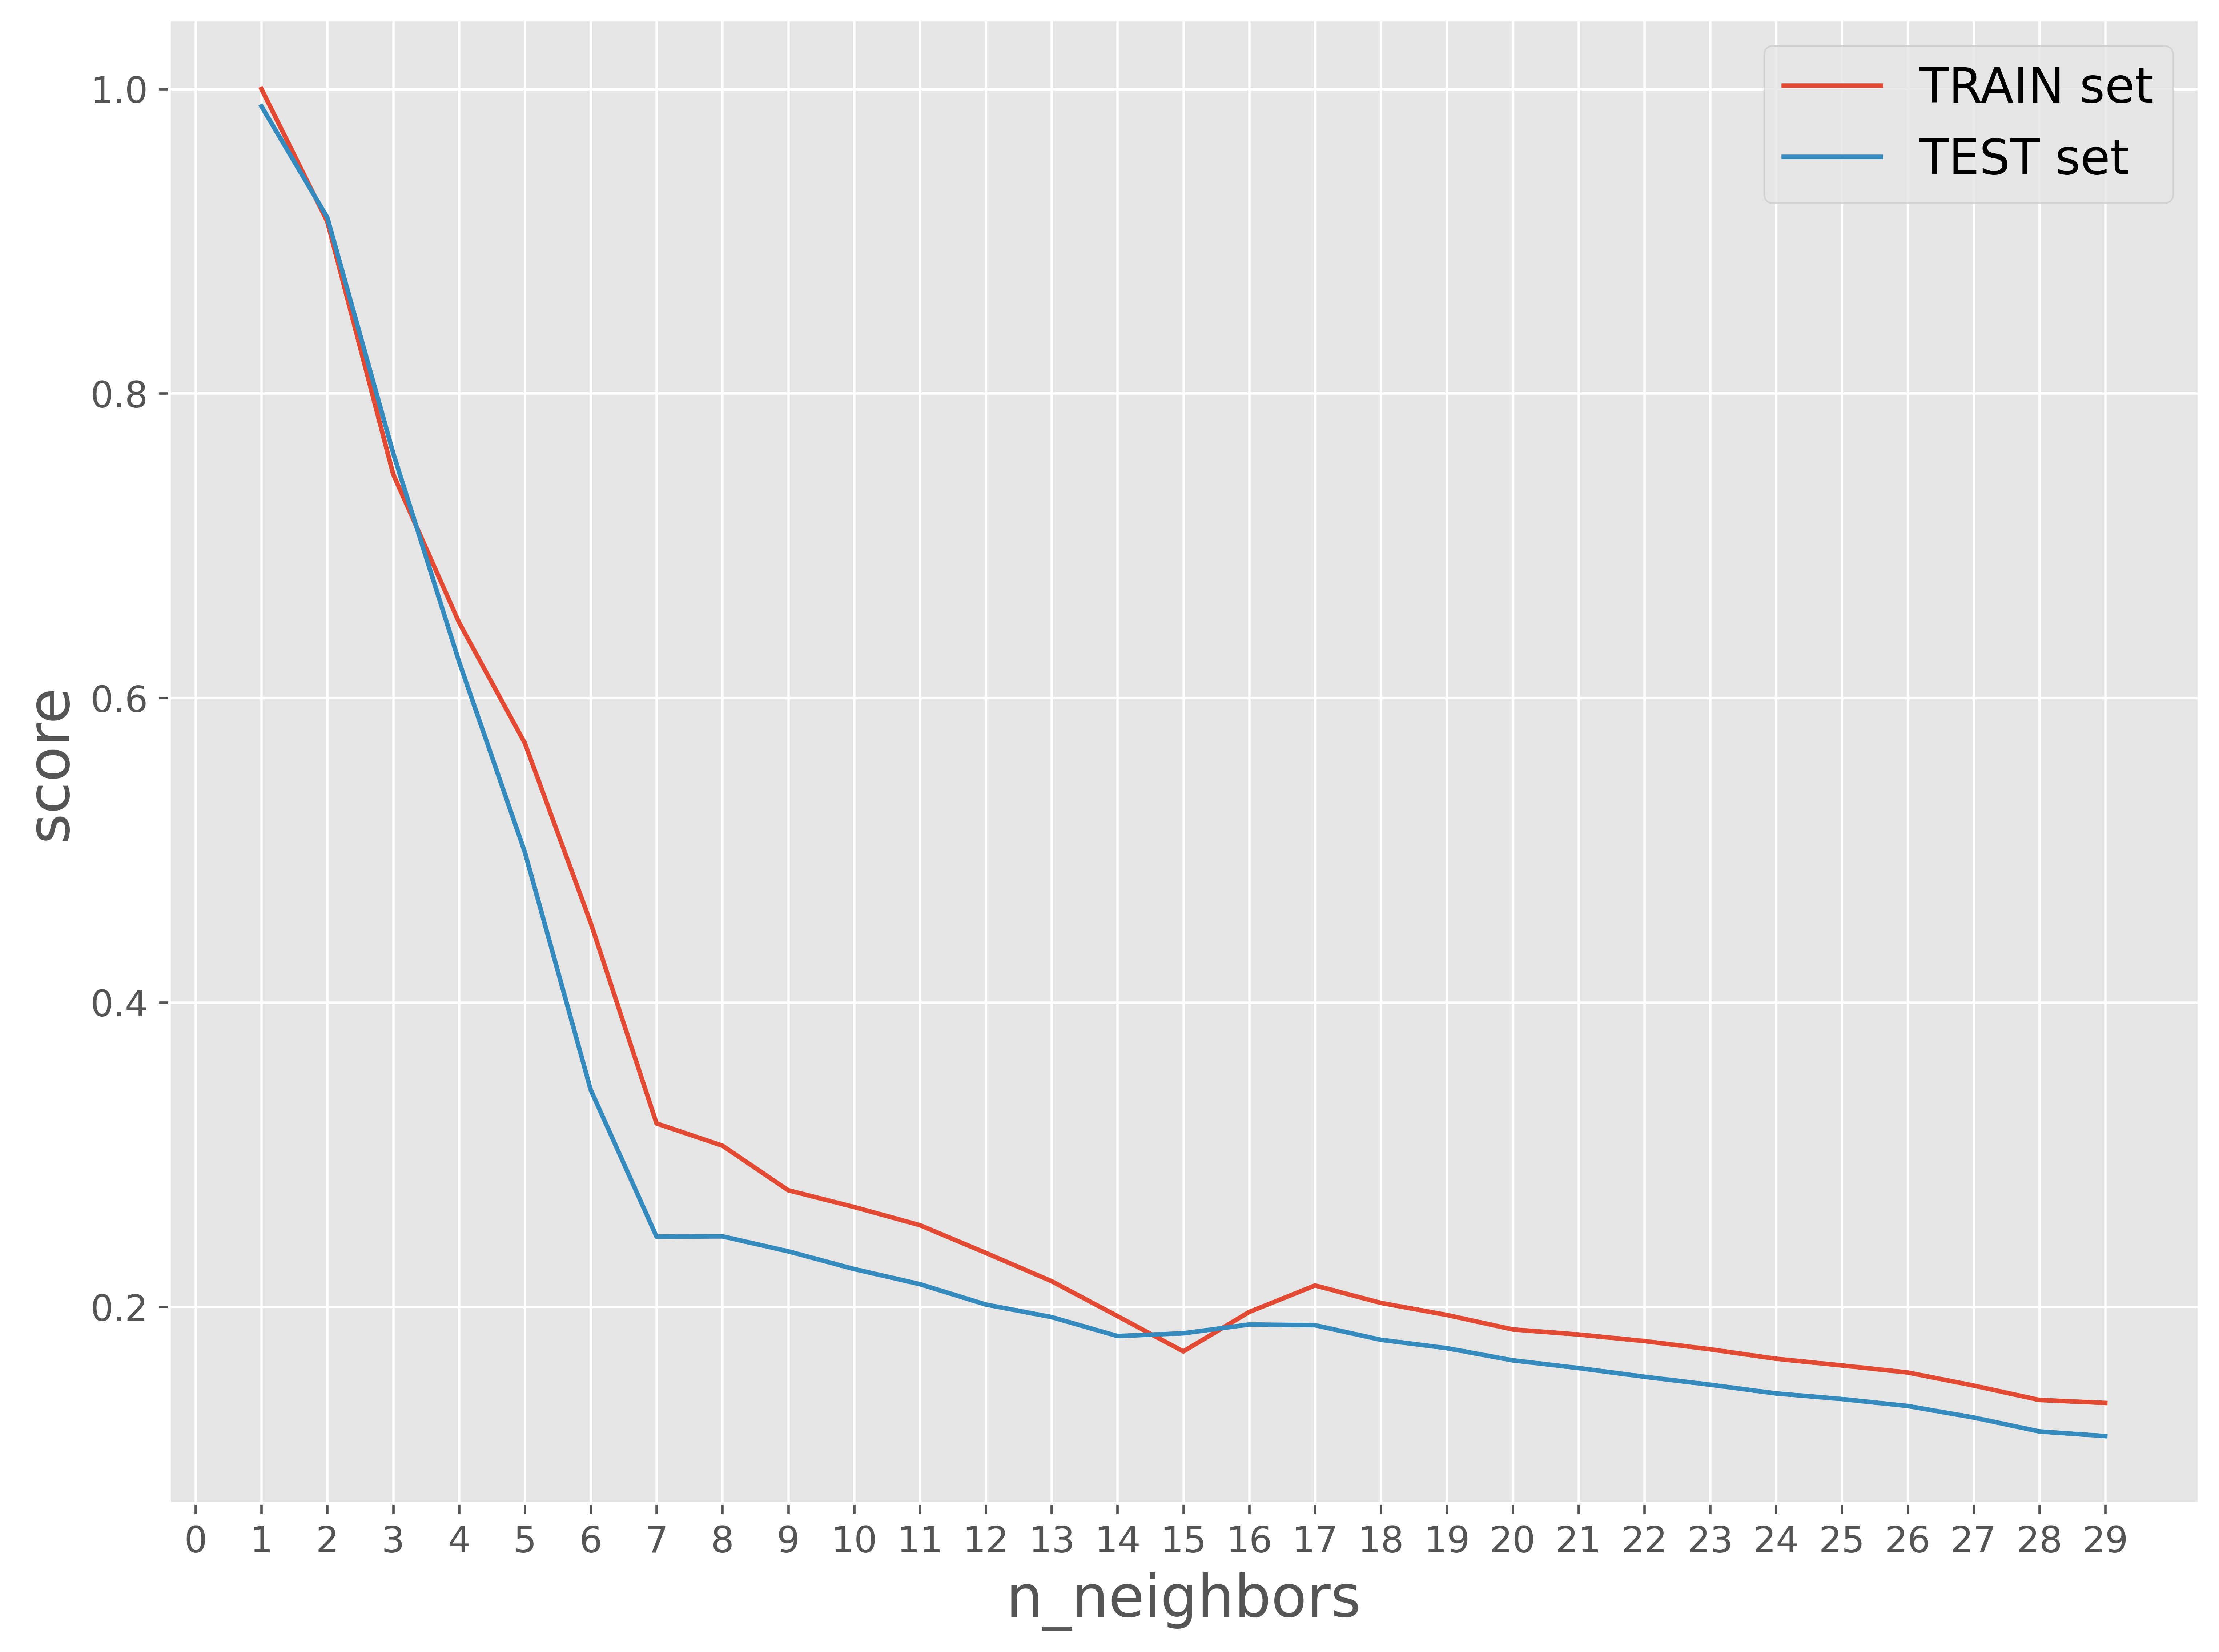

In [99]:
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

y_test=np.ravel(y_test)

train_acc = []
test_acc = []

for n in range(1,30):
    clf = KNeighborsRegressor(n_jobs=-1, n_neighbors=n)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.figure(figsize=(12, 9))
plt.plot(range(1, 30), train_acc, label='TRAIN set')
plt.plot(range(1, 30), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.xticks(np.arange(0, 30, step=1))
plt.legend()
plt.show()

In [88]:
n_neighbors = 10
random_state = 7777

# Load Digits dataset

In [118]:
X = test_df.drop(["Maximum Installs", "Installs", "Released"], axis = 1)
y = test_df[['Installs']]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

In [119]:
X_test

Category  Size  Minimum Android  Content Rating  Ad Supported  \
9364       24.0  30.0             17.0             0.0           0.0   
8975        0.0  54.0             14.0             3.0           1.0   
8686       17.0   8.9             19.0             1.0           0.0   
8190        2.0  10.0             17.0             0.0           1.0   
17534      44.0  11.0             17.0             0.0           1.0   
...         ...   ...              ...             ...           ...   
19302       7.0   1.2              5.0             0.0           1.0   
17093      31.0   4.6             19.0             0.0           0.0   
5976       15.0  37.0             15.0             0.0           0.0   
10725       4.0   7.9             15.0             0.0           0.0   
17481      29.0   3.1             14.0             3.0           0.0   

       In App Purchases  
9364                0.0  
8975                0.0  
8686                0.0  
8190                0.0  
17534               0.0  
...                 ...  
19302               0.0  
17093               0.0  
5976                0.0  
10725               0.0  
17481               0.0  

[3756 rows x 6 columns]

In [140]:
def plotKNN(knn_model):


    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(), PCA(n_components=2))

    # Use a nearest neighbor classifier to evaluate the methods
    knn = knn_model

    # Make a list of the methods to be compared
    dim_reduction_methods = [("PCA", pca)]

    # plt.figure()
    for i, (name, model) in enumerate(dim_reduction_methods):
        plt.figure()
        # plt.subplot(1, 3, i + 1, aspect=1)

        # Fit the method's model
        model.fit(X_train, y_train)

        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(model.transform(X_train), y_train)

        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(model.transform(X_test), y_test)

        # Embed the data set in 2 dimensions using the fitted model
        X_embedded = model.transform(X_test)

        # Plot the projected points and show the evaluation score
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test["Installs"],s=30, cmap="Set1")
        plt.title(
            "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, knn.n_neighbors, acc_knn)
        )
    plt.show()

In [141]:
from sklearn.model_selection import RandomizedSearchCV


#Create KNN model
knn = KNeighborsClassifier()
#Set Kfold for k == 5
cv = KFold(n_splits=5)

ss = StandardScaler()

fold = 0
for train_index, test_index in cv.split(X_test):

    fold += 1
    train_X, test_X = X_train.iloc[train_index], X_test.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_test.iloc[test_index]


    #Predict value by KNN when k == 5
    model_n_7 = KNeighborsClassifier(n_neighbors = 1)
    model_n_7.fit(ss.fit_transform(train_X), train_y)

    print(f'Result of {fold} fold')
    print(f'Result when k == 5 => {model_n_7.score(ss.fit_transform(test_X), test_y)}')

Result of 1 fold
Result when k == 5 => 0.38563829787234044
Result of 2 fold
Result when k == 5 => 0.4047936085219707
Result of 3 fold
Result when k == 5 => 0.35286284953395475
Result of 4 fold
Result when k == 5 => 0.33022636484687085
Result of 5 fold
Result when k == 5 => 0.3914780292942743


--------With GridSearch--------


/opt/homebrew/Caskroom/miniforge/base/envs/RL_Sutton/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/Caskroom/miniforge/base/envs/RL_Sutton/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/Caskroom/miniforge/base/envs/RL_Sutton/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/homebrew/Caskroom/miniforge/base/envs/RL_Sutton/lib/python3.8/site-packages/sklearn/ne

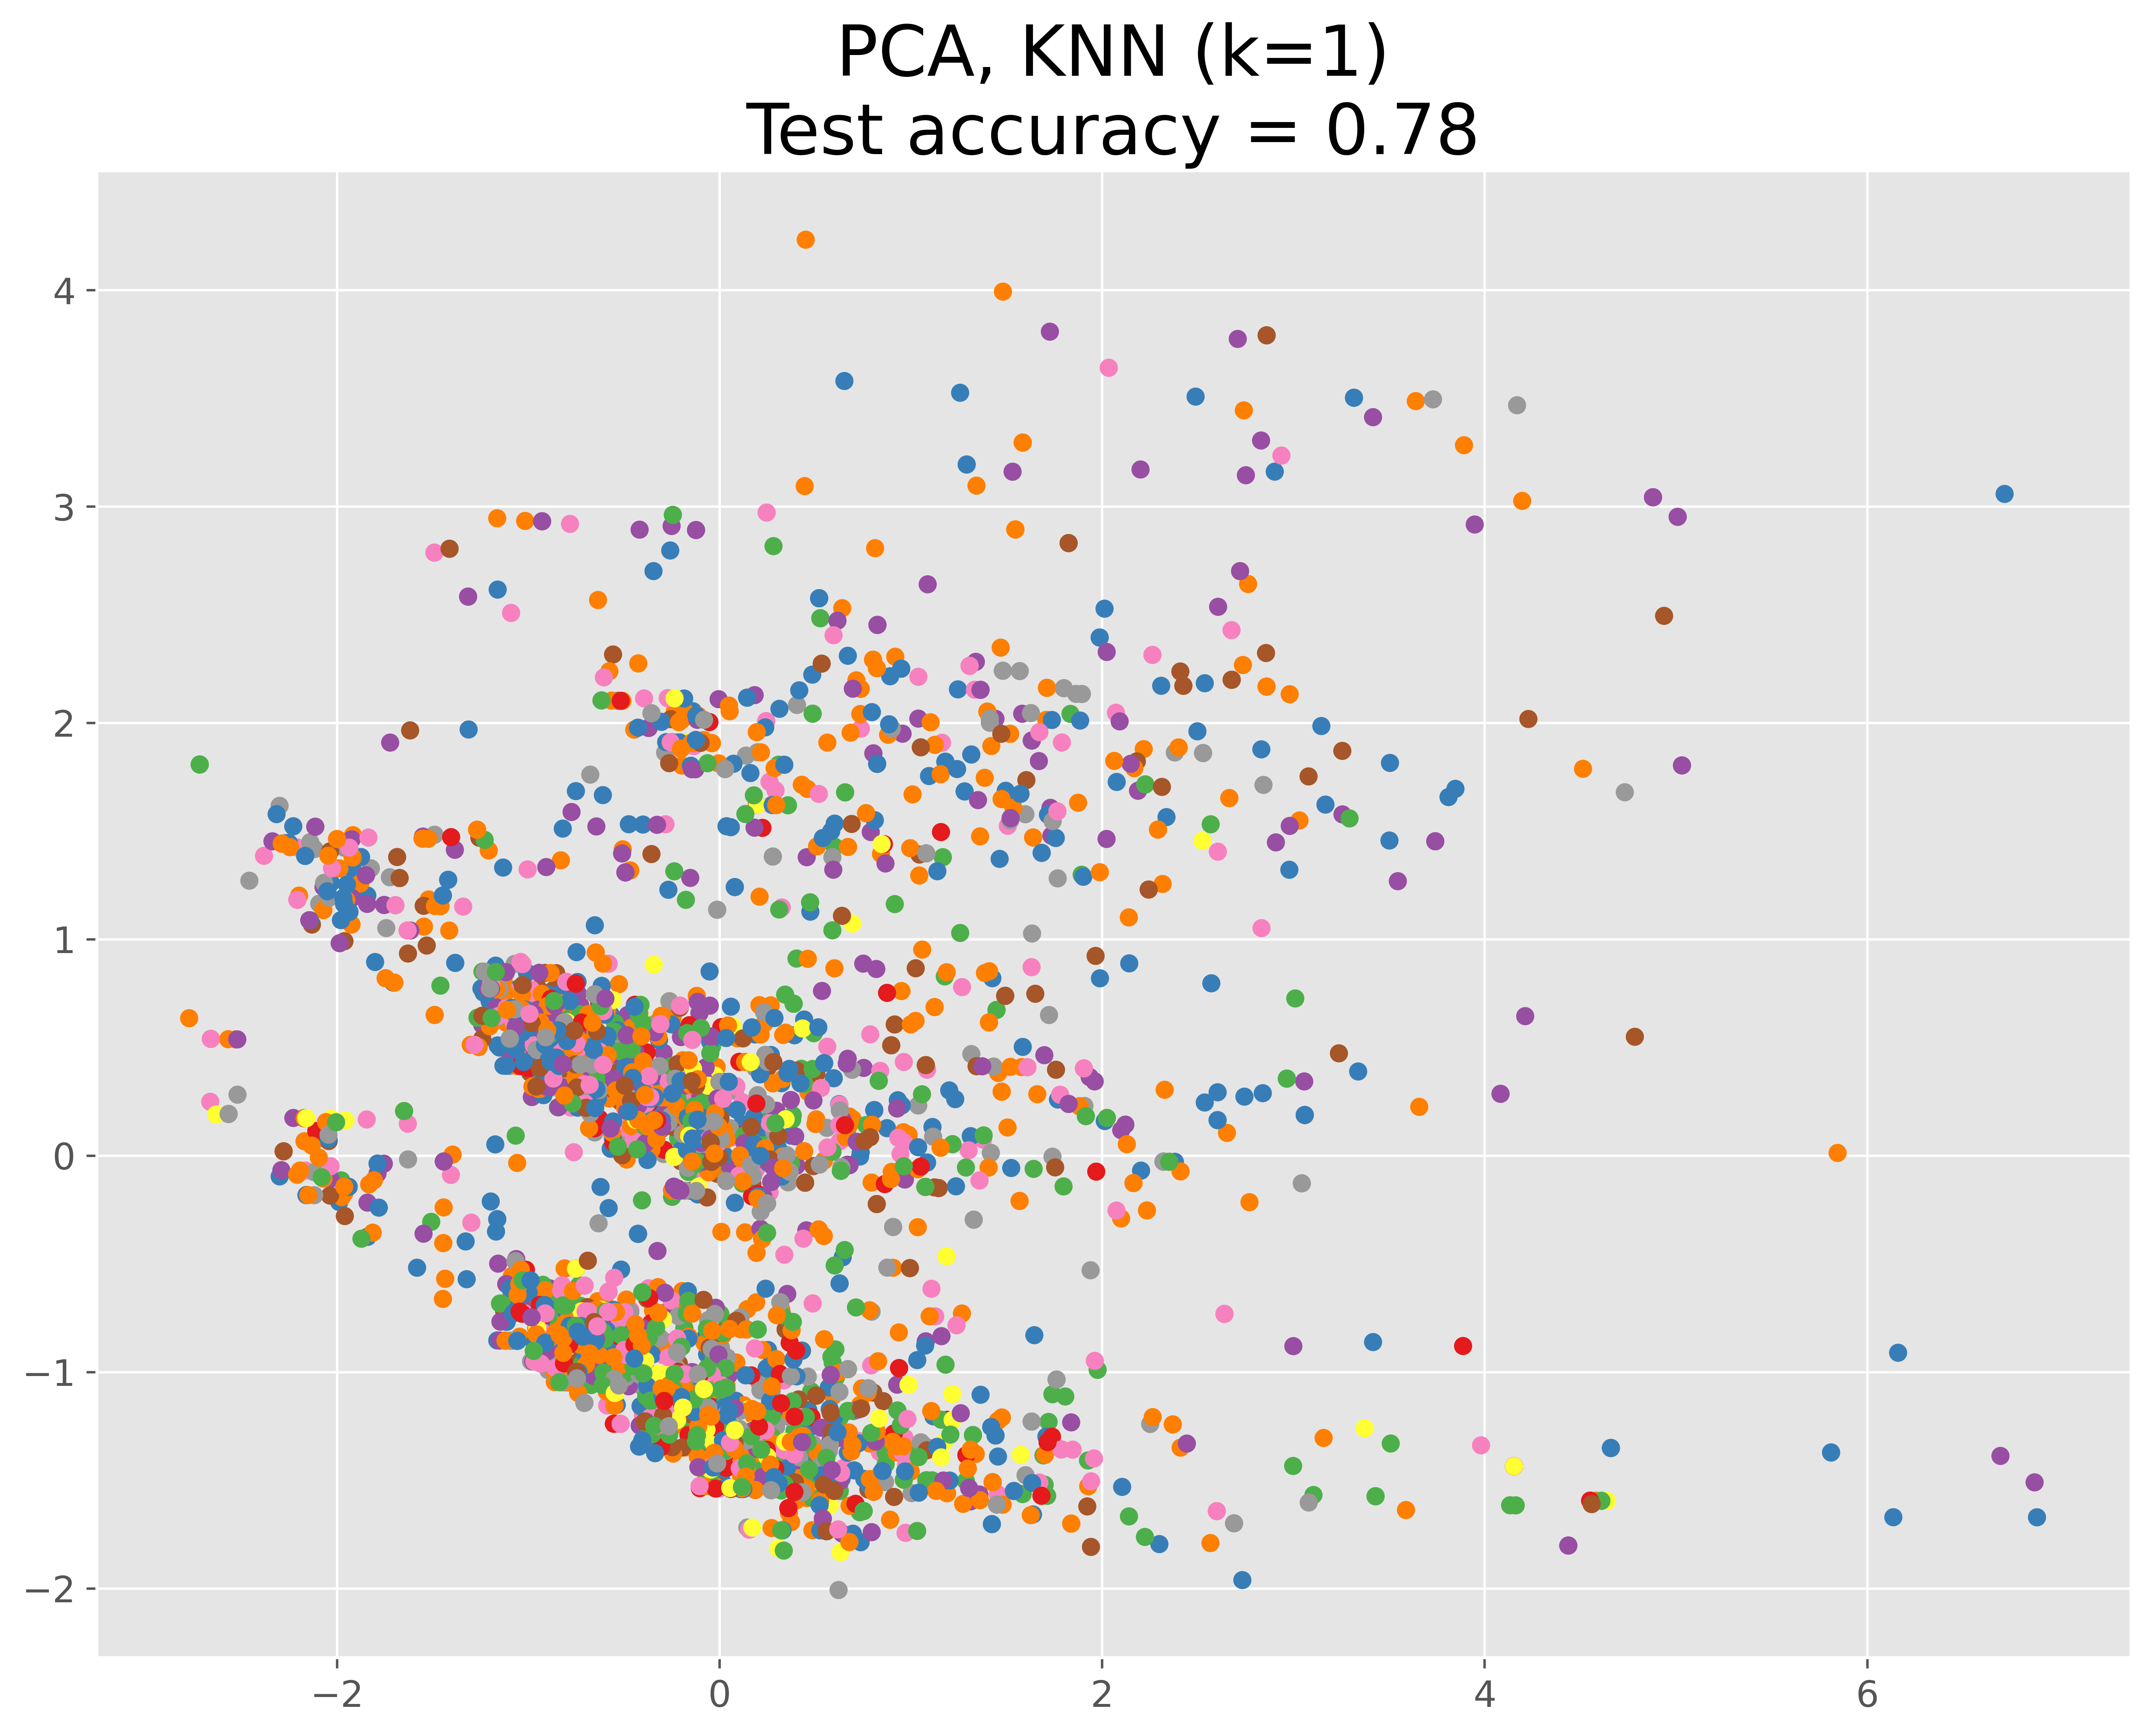

In [142]:

#Set neighbors matrix for grid searching
param_grid = dict(n_neighbors = np.arange(1, 30))

#Hyperparameter tuning by grid searching
print("--------With GridSearch--------")
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
grid_search.fit(ss.fit_transform(X_train), y_train)
optimal_knn = grid_search.best_estimator_
plotKNN(optimal_knn)

print()

--------With Randomized GridSearch--------
Optimal k is 1


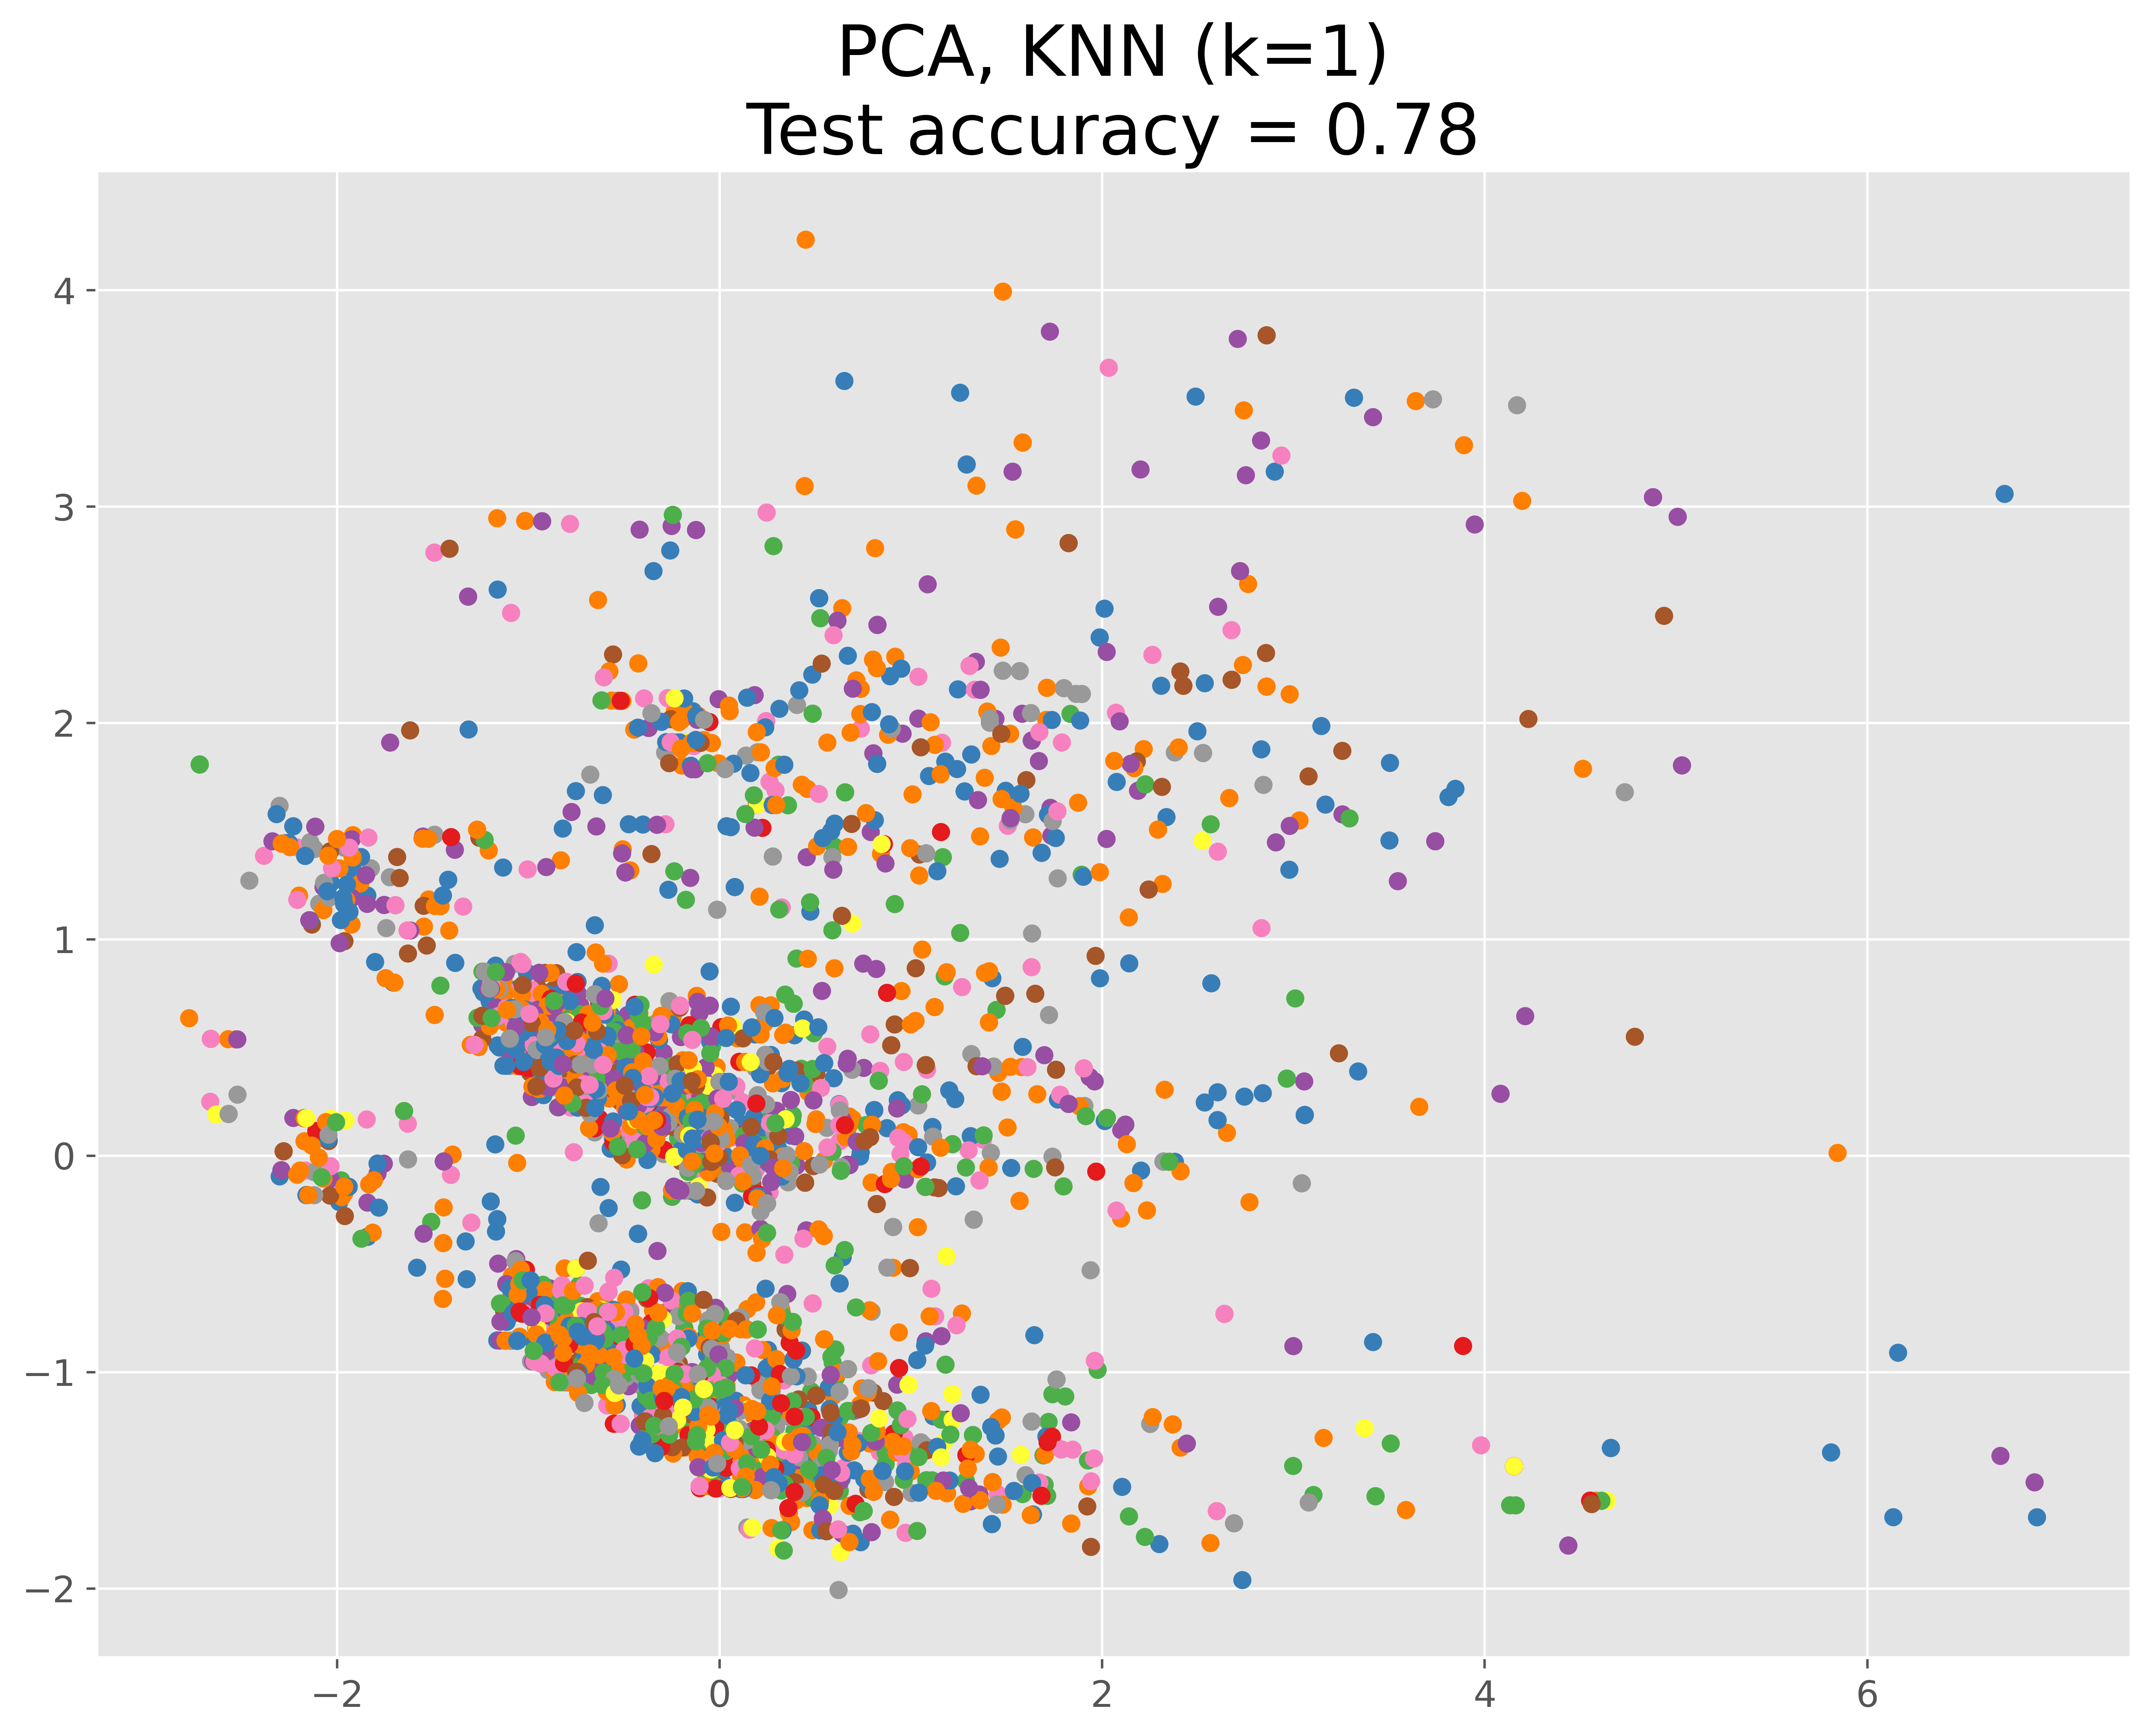

In [136]:
#Hyperparameter tuning by randomized grid searching
print("--------With Randomized GridSearch--------")
randomized_grid_search = RandomizedSearchCV(knn, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)
randomized_grid_search.fit(ss.fit_transform(X_train), y_train)
optimal_knn = grid_search.best_estimator_
print(f'Optimal k is {optimal_knn.n_neighbors}')
plotKNN(optimal_knn)
print()




